In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install split-folders tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import numpy as np
import splitfolders
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
base_dir = '/content/drive/MyDrive/Dataset'

Split Dataset into 3 part: Train, Val, and Test

In [17]:
splitfolders.ratio(
    base_dir,
    output='Capstone',
    ratio=(.6, 0.3,0.1)
)

Copying files: 2375 files [01:20, 29.43 files/s]


In [18]:
train_dir = 'Capstone/train'
val_dir = 'Capstone/val' 
test_dir = 'Capstone/test'

os.listdir(train_dir)

['Hispa', 'Healthy', 'BrownSpot', 'LeafBlast']

In [19]:
class_name = ['Healthy', 'Hispa', 'BrownSpot', 'LeafBlast']

Data Augmentation

In [20]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=0.45, 
                    width_shift_range=0.2,
                     height_shift_range=0.2,
                     zoom_range=(0.2), 
                     fill_mode='nearest', 
                    horizontal_flip=True,
                    )

test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

In [21]:

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150,150), 
    batch_size=45, 
    shuffle=True,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(150,150),
    batch_size=45,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=45,
    shuffle=True,
    class_mode='categorical'
)

Found 1661 images belonging to 4 classes.
Found 712 images belonging to 4 classes.
Found 241 images belonging to 4 classes.


Modeling

In [22]:
from keras.callbacks import EarlyStopping
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=3)

In [23]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience = 2,
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

In [24]:
from tensorflow.keras.applications import InceptionV3
tfmodel = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(150,150,3))

In [25]:
from keras.models import Sequential
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D

In [26]:
model = Sequential()
model.add(tfmodel)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))      
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                      

In [28]:
history = model.fit(train_generator,
                    epochs=50,
                    callbacks=[monitor_val_acc,reduce_lr],
                    validation_data=validation_generator)

Epoch 1/50
37/37 [==============================] - 372s 10s/step - loss: 1.3545 - accuracy: 0.3462 - val_loss: 1.6225 - val_accuracy: 0.2514 - lr: 1.0000e-04
Epoch 2/50
37/37 [==============================] - 304s 8s/step - loss: 1.1892 - accuracy: 0.4816 - val_loss: 1.8208 - val_accuracy: 0.4115 - lr: 1.0000e-04
Epoch 3/50
37/37 [==============================] - 356s 10s/step - loss: 1.0275 - accuracy: 0.5864 - val_loss: 1.3217 - val_accuracy: 0.5267 - lr: 1.0000e-04
Epoch 4/50
37/37 [==============================] - 303s 8s/step - loss: 0.9187 - accuracy: 0.6231 - val_loss: 1.1340 - val_accuracy: 0.5829 - lr: 1.0000e-04
Epoch 5/50
37/37 [==============================] - 300s 8s/step - loss: 0.8356 - accuracy: 0.6809 - val_loss: 0.8802 - val_accuracy: 0.6629 - lr: 1.0000e-04
Epoch 6/50
37/37 [==============================] - 303s 8s/step - loss: 0.7975 - accuracy: 0.6719 - val_loss: 0.8952 - val_accuracy: 0.6798 - lr: 1.0000e-04
Epoch 7/50
37/37 [==============================] 

In [29]:
model.save("Model.h5")

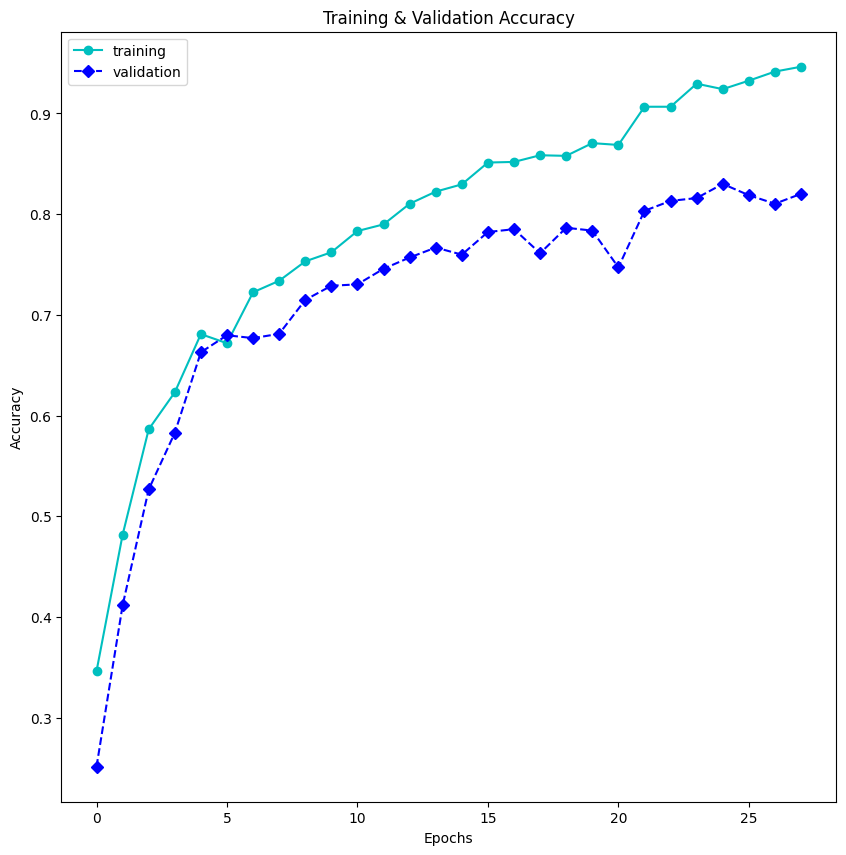

In [31]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['accuracy'])), 
         history.history['accuracy'],
         'co-',
         label='training')
plt.plot(range(len(history.history['val_accuracy'])), 
         history.history['val_accuracy'],
         'bD--',
         label='validation')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

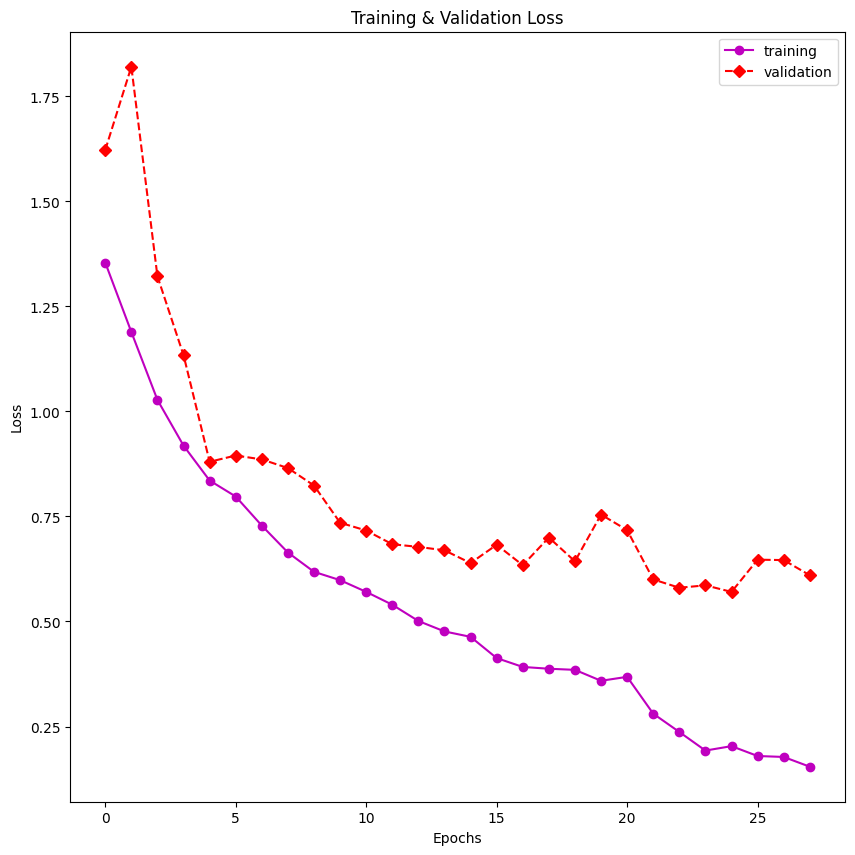

In [32]:
plt.figure(1, figsize=(10,10))
plt.plot(range(len(history.history['loss'])), 
         history.history['loss'],
         'mo-',
         label='training')
plt.plot(range(len(history.history['val_loss'])), 
         history.history['val_loss'],
         'rD--',
         label='validation')
plt.title('Training & Validation Loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()